# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In [24]:
# fastai uses older version of torch
# Google colab, by default, uses a later
# reason: get rid of user warnings due to the changes made in the later version
# of pytorch

!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 43.6MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [2]:
from fastai.vision import *

In [3]:
!nvidia-smi

Sat Aug  1 03:18:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get Data

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
path = "/content/drive/My Drive/FASTAI_COURSE/orange_dataset"

In [6]:
# Load data and normalize
data = ImageDataBunch.from_folder(path,ds_tfms=get_transforms(), bs=32, size=224, num_workers=4).normalize(imagenet_stats)

## View data

In [ ]:
#No need for random seed because I've already split the data.
#np.random.seed(42)
#data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
#        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [7]:
data.classes

['kwek-kwek', 'orange-fruit']

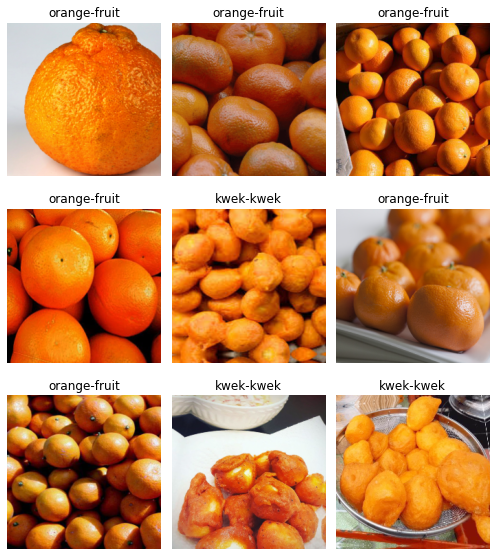

In [8]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
# classes, number of classes, size of training set, size of validation set
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['kwek-kwek', 'orange-fruit'], 2, 41, 20)

## Train model

In [34]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [35]:
learn.fit_one_cycle(4)

In [36]:
learn.save('stage-1')

In [37]:
# unfreeze the whole network (to be used for finetuning the weights of all layers)
learn.unfreeze()

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


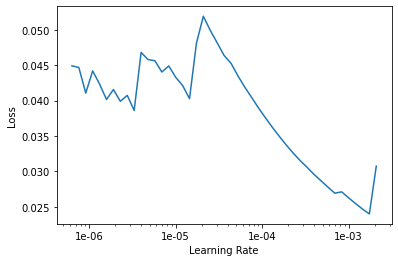

In [39]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [32]:
# load this weights if nasira mo yung weights sa finetuning
learn.load('stage-1');

In [40]:
learn.fit_one_cycle(2, max_lr=slice(1e-45,1e-35))

In [41]:
learn.save('stage-2')

## Interpretation

In [42]:
learn.load('stage-2');

In [43]:
interp = ClassificationInterpretation.from_learner(learn)

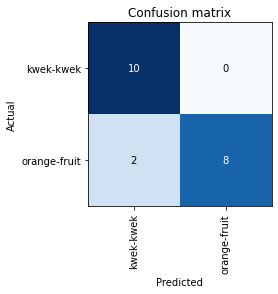

In [44]:
interp.plot_confusion_matrix()

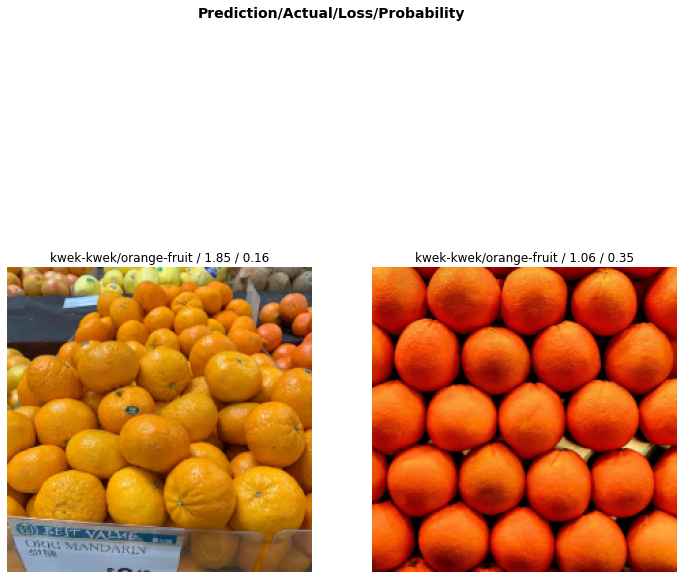

In [54]:
interp.plot_top_losses(2)

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')

In [57]:
path

'/content/drive/My Drive/FASTAI_COURSE/orange_dataset'

In [76]:
kwek1_path = f'{path}/kwek1.JPG' # ang arte ng extension nya all caps
orange1_path = f'{path}/orange1.jpg'
kwek2_path = f'{path}/kwek2.jpg'
orange2_path = f'{path}/orange2.jpg'

kwek1_path, orange1_path, kwek2_path, orange2_path

('/content/drive/My Drive/FASTAI_COURSE/orange_dataset/kwek1.JPG',
 '/content/drive/My Drive/FASTAI_COURSE/orange_dataset/orange1.jpg',
 '/content/drive/My Drive/FASTAI_COURSE/orange_dataset/kwek2.jpg',
 '/content/drive/My Drive/FASTAI_COURSE/orange_dataset/orange2.jpg')

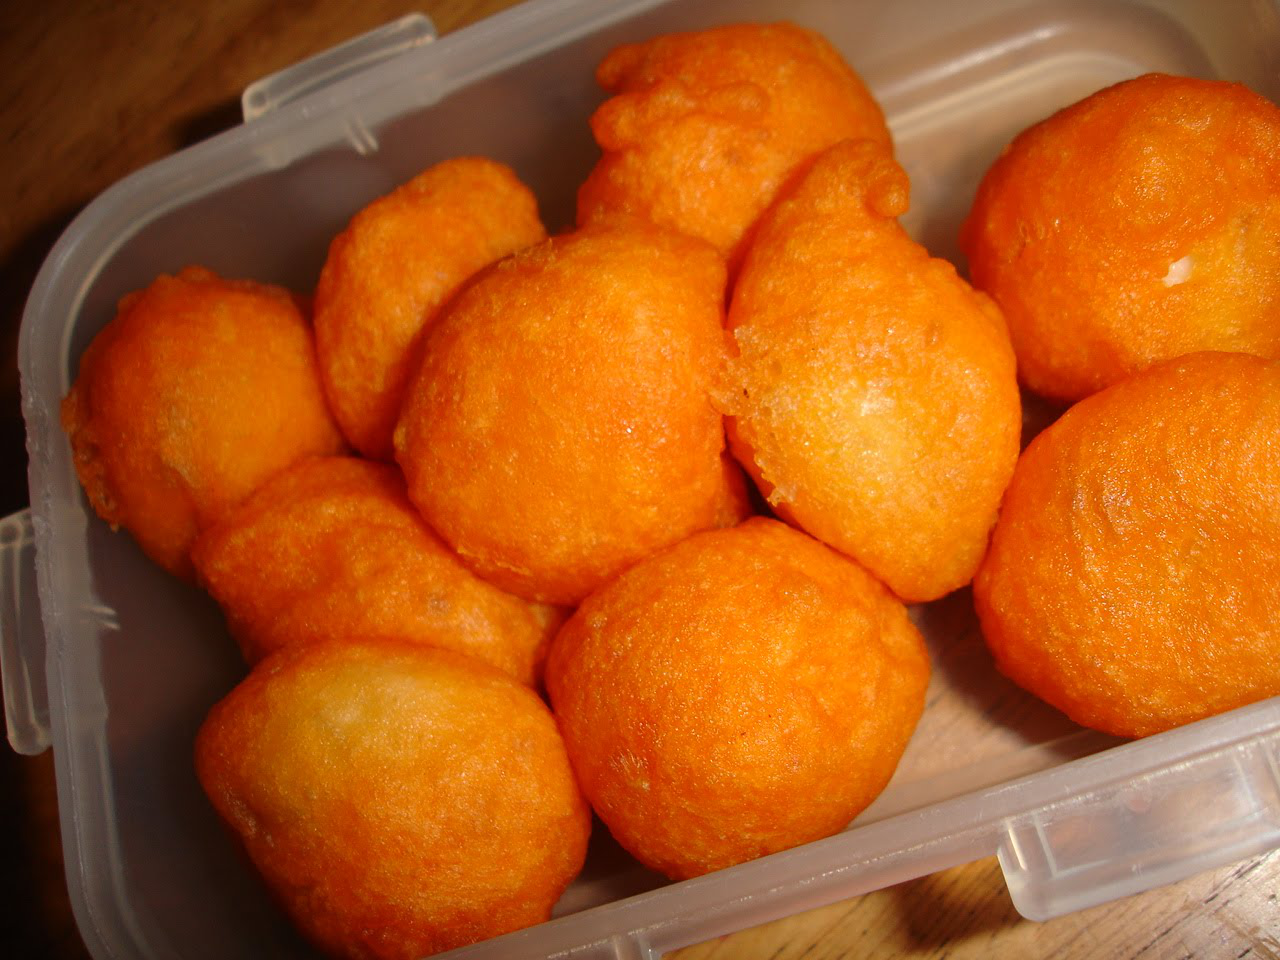

kwek-kwek


In [93]:
kwek1_img = open_image(kwek1_path)
pred_class,pred_idx,outputs = learn.predict(kwek1_img)
display(kwek1_img)
print(pred_class.obj)

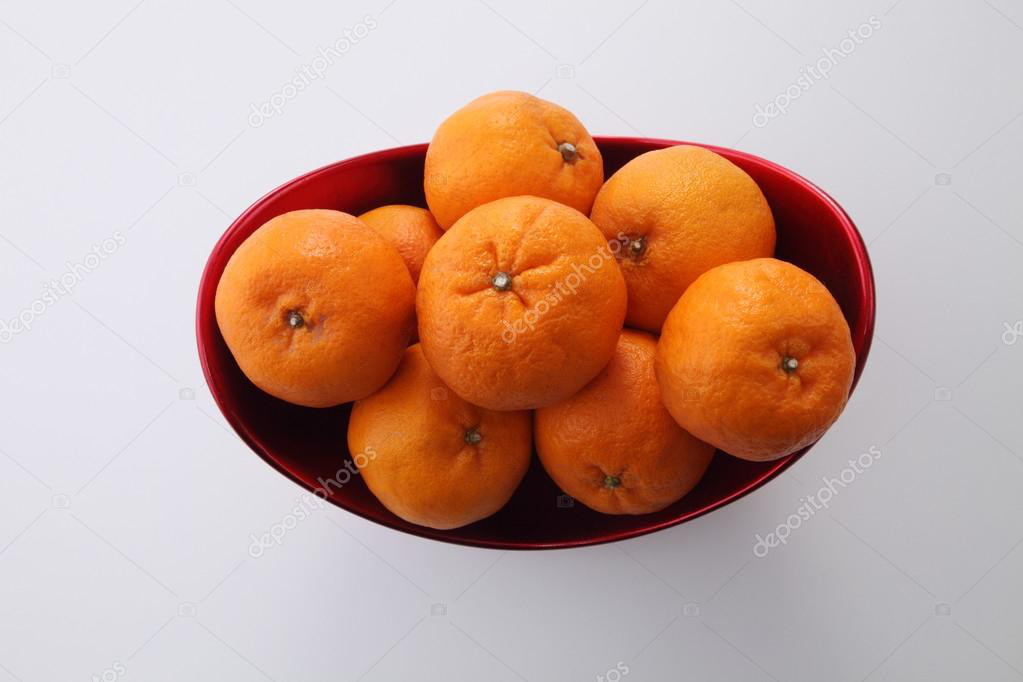

orange-fruit


In [94]:
orange1_img = open_image(orange1_path)
pred_class,pred_idx,outputs = learn.predict(orange1_img)

display(orange1_img)
print(pred_class.obj)

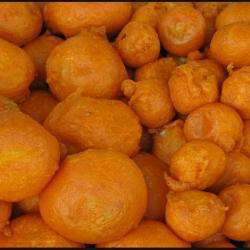

kwek-kwek


In [91]:
kwek2_img = open_image(kwek2_path)
pred_class,pred_idx,outputs = learn.predict(kwek2_img)
display(kwek2_img)
print(pred_class.obj)

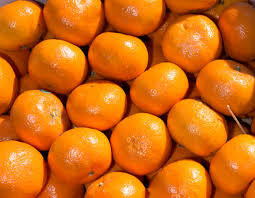

orange-fruit


In [92]:
orange2_img = open_image(orange2_path)
pred_class,pred_idx,outputs = learn.predict(orange2_img)

display(orange2_img)
print(pred_class.obj)

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = load_learner(path)

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

Total time: 00:13
epoch  train_loss  valid_loss  error_rate       
1      12.220007   1144188288.000000  0.765957    (00:13)



### Learning rate (LR) too low

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

Total time: 01:07
epoch  train_loss  valid_loss  error_rate
1      1.349151    1.062807    0.609929    (00:13)
2      1.373262    1.045115    0.546099    (00:13)
3      1.346169    1.006288    0.468085    (00:13)
4      1.334486    0.978713    0.453901    (00:13)
5      1.320978    0.978108    0.446809    (00:13)



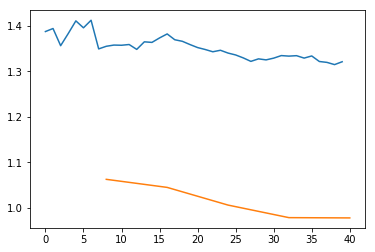

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:14
epoch  train_loss  valid_loss  error_rate
1      0.602823    0.119616    0.049645    (00:14)



### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      1.513021    1.041628    0.507326    (00:13)
2      1.290093    0.994758    0.443223    (00:09)
3      1.185764    0.936145    0.410256    (00:09)
4      1.117229    0.838402    0.322344    (00:09)
5      1.022635    0.734872    0.252747    (00:09)
6      0.951374    0.627288    0.192308    (00:10)
7      0.916111    0.558621    0.184982    (00:09)
8      0.839068    0.503755    0.177656    (00:09)
9      0.749610    0.433475    0.144689    (00:09)
10     0.678583    0.367560    0.124542    (00:09)
11     0.615280    0.327029    0.100733    (00:10)
12     0.558776    0.298989    0.095238    (00:09)
13     0.518109    0.266998    0.084249    (00:09)
14     0.476290    0.257858    0.084249    (00:09)
15     0.436865    0.227299    0.067766    (00:09)
16     0.457189    0.236593    0.078755    (00:10)
17     0.420905    0.240185    0.080586    (00:10)
18     0.395686    0.255465    0.082418    (00:09)
19     0.373232    0.2